In [1]:
import sympy as sp

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sympy.physics.units.quantities as sq

In [4]:
from sympy.physics.quantum.constants import hbar

In [5]:
PSI_FUNCTION = sp.Function( "psi" )
POTENTIAL_FUNCTION = sp.Function( "V" )
TOTAL_ENERGY_SYMBOL = sq.Symbol( 'E', nonzero = True, positive = True )
MASS_SYMBOL = sq.Quantity( 'm', positive = True, nonzero = True )
#REDUCED_PLANCK_CONSTANT_SYMBOL = sq.Symbol( "hbar" )
POSITION_SYMBOL = sp.Symbol( 'x', positive = True )

def time_independent_schroedinger_equation( 
            psi = PSI_FUNCTION, 
            potential = POTENTIAL_FUNCTION, 
            total_energy = TOTAL_ENERGY_SYMBOL, 
            mass = MASS_SYMBOL, 
            reduced_planck_constant = hbar, #REDUCED_PLANCK_CONSTANT_SYMBOL, 
            position = POSITION_SYMBOL 
        ): 
    return sp.Eq( 
            ( ( -( reduced_planck_constant ** 2 ) / ( 2 * mass ) ) \
                    * sp.Derivative( psi( position ), ( position, 2 ) ) )
                    + ( potential( position ) * psi( position ) ), 
            total_energy * psi( position ) 
        )


In [6]:
set_equal = lambda to_set, value : sp.Eq( to_set, value )
both_sides = lambda equation, opreation : sp.Eq( opreation( equation.lhs ), opreation( equation.rhs ) )
equation_to_dict = lambda equation : { equation.lhs : equation.rhs }

In [7]:
hbar_eq = sp.Eq( hbar, sp.physics.units.planck / ( 2 * sp.pi ) )

In [8]:
hbar_eq

Eq(hbar, planck/(2*pi))

In [9]:
psi = PSI_FUNCTION
potential = POTENTIAL_FUNCTION
total_energy = TOTAL_ENERGY_SYMBOL
mass = MASS_SYMBOL
#reduced_planck_constant = REDUCED_PLANCK_CONSTANT_SYMBOL
x = POSITION_SYMBOL

In [10]:
k = sp.Symbol( 'k' )

In [11]:
k_squared = sp.Eq( k ** 2, ( ( 2 * total_energy * mass ) / ( hbar ** 2 ) ) )

In [12]:
k_squared

Eq(k**2, 2*m*E/hbar**2)

In [13]:
class ZeroPotential( sp.Function ): 
    @classmethod
    def eval( cls, position ):
        return 0

In [14]:
#https://docs.sympy.org/latest/modules/assumptions/index.html#querying
#https://docs.sympy.org/latest/modules/codegen.html#module-sympy.codegen.cxxnodes

class Potential( sp.Function ): 
    DEFAULT_POTENTIAL = sp.Symbol( "V_0" )
    @classmethod
    def eval( cls, position, potential = DEFAULT_POTENTIAL ): 
        return potential

In [15]:
class TunnelPotential( sp.Function ): 
    DEFAULT_WELL_LENGTH = sp.Symbol( 'L' )
    DEFAULT_POTENTIAL = Potential.DEFAULT_POTENTIAL
    DEFAULT_START = 0
    @classmethod
    def eval( cls, position, length = DEFAULT_WELL_LENGTH, 
             start = DEFAULT_START, potential = DEFAULT_POTENTIAL ): 
        if position < start or position > sp.simplify( length + start ): 
            return ZeroPotential.eval( position )
        return Potential.eval( position, potential )

In [16]:
class Stepper: 

    LEFT = "LEFT", 
    RIGHT = "RIGHT"
    
    def __init__( self, first_step, new_steps = None ): 
        self.steps = new_steps if new_steps else []
        self.steps.append( first_step )
        self.chaining = False
    
    def step_number( self, step = None ): 
        return ( len( self.steps ) - 1 ) if not step else step
    
    def last_step( self, step = None ):
        return self.steps[ self.step_number( step ) ]
    
    def _return_chain( self, step, chain ): 
        return self if ( chain or self.chaining ) else step        
    
    def add_step( self, new_step, chain = False ):
        self.steps.append( new_step )
        return self._return_chain( self.steps[ -1 ], chain )

    def operate( self, operation, step = None, chain = False ):
        self.steps.append( operation( self.last_step( step ) ) )
        return self._return_chain( self.steps[ -1 ], chain )

    def manipulate( self, operation, chain = False ): 
        return self._return_chain( self.add_step( 
                both_sides( self.last_step(), operation ) ), 
                chain 
            )
    
    def delete_step( self, step ): 
        old_step = self.steps[ step ]
        del self.steps[ step ]
        return old_step
    
    def undo( self, step = None, chain = False ): 
        return self._return_chain( 
                self.delete_step( self.step_number( step ) ), 
                chain 
            )
    
    def clone( self, from_step = None ):
        return self.branch( lambda blank : blank, from_step )
    
    def branch( self, operation = None, from_step = None ): 
        from_step = self.step_number( from_step )
        return Stepper( 
                both_sides( self.last_step( from_step ), operation ), 
                self.steps[ : self.step_number( from_step ) : ], 
            )
    
    def substitute_constant( self, constant, chain = False ):
            return self.operate( lambda step : step.subs( { constant.rhs : constant.lhs } ) )
    
    def negate_add( self, side_to_negate_add, chain = False ): 
        last_step = self.last_step()
        return self.manipulate( 
                lambda side : side + -( 
                    last_step.lhs if side_to_negate_add == Stepper.LEFT 
                            else last_step.rhs 
                        ), 
                chain 
            )
    
    def rename( self, old_symbol, new_symbol_name, chain = False ): 
        last_step = self.last_step()
        assert old_symbol in last_step.atoms() or old_symbol in last_step.atoms( sp.Function )
        return self.add_step( last_step.subs( 
            old_symbol if type( old_symbol ) == dict \
                    else { old_symbol : new_symbol_name } ), chain 
                )
    
    def chain( self, operation ):
        self.chaining = True
        operation( self )
        self.chaining = False
        return self
    
    def begin_chain( self ): 
        self.chaining = True
        return self
    
    def end_chain( self ): 
        self.chaining = False
        return self


In [17]:
k_squared

Eq(k**2, 2*m*E/hbar**2)

In [18]:
psi_region = [
        Stepper( time_independent_schroedinger_equation( potential = ZeroPotential ) ), 
        Stepper( time_independent_schroedinger_equation( potential = Potential ) ), 
        Stepper( time_independent_schroedinger_equation( potential = ZeroPotential ) )
    ]

In [19]:
psi_region[ 0 ].last_step()

Eq(-hbar**2*Derivative(psi(x), (x, 2))/(2*m), E*psi(x))

In [20]:
psi_region[ 0 ].manipulate( lambda side : ( side - psi_region[ 0 ].last_step().rhs ).simplify() )

Eq(-E*psi(x) - hbar**2*Derivative(psi(x), (x, 2))/(2*m), 0)

In [21]:
psi_region[ 0 ].manipulate( lambda side : -( side / total_energy ).simplify() )

Eq(psi(x) + hbar**2*Derivative(psi(x), (x, 2))/(2*m*E), 0)

In [22]:
psi_region[ 0 ].manipulate( lambda side : side - psi( x ) )

Eq(hbar**2*Derivative(psi(x), (x, 2))/(2*m*E), -psi(x))

In [23]:
psi_region[ 0 ].manipulate( lambda side : side * k_squared.rhs )

Eq(Derivative(psi(x), (x, 2)), -2*m*E*psi(x)/hbar**2)

In [24]:
psi_region[ 0 ].manipulate( lambda side : side / psi( x ) )

Eq(Derivative(psi(x), (x, 2))/psi(x), -2*m*E/hbar**2)

In [25]:
k_squared

Eq(k**2, 2*m*E/hbar**2)

In [26]:
psi_region[ 0 ].substitute_constant( k_squared )

Eq(Derivative(psi(x), (x, 2))/psi(x), -k**2)

In [27]:
psi_region[ 0 ].manipulate( lambda side : side * psi( x ) )

Eq(Derivative(psi(x), (x, 2)), -k**2*psi(x))

In [28]:
psi_region[ 0 ].negate_add( Stepper.RIGHT )

Eq(k**2*psi(x) + Derivative(psi(x), (x, 2)), 0)

In [29]:
# For later

psi_region[ 2 ] = psi_region[ 0 ].clone()

In [30]:
psi_region[ 2 ].last_step()

Eq(k**2*psi(x) + Derivative(psi(x), (x, 2)), 0)

In [31]:
k_0 = sp.Symbol( "k_0" )

In [32]:
psi_region[ 0 ].rename( k, k_0 )

Eq(k_0**2*psi(x) + Derivative(psi(x), (x, 2)), 0)

In [33]:
diff_sol = sp.solvers.ode.dsolve( psi_region[ 0 ].last_step().lhs, 0, ivar = x )
#ics = { psi( 0 ): 0, psi( well_length ): 0 }

In [34]:
diff_sol

Eq(psi(x), C1*exp(-I*k_0*x) + C2*exp(I*k_0*x))

In [35]:
psi_region[ 0 ].add_step( diff_sol )

Eq(psi(x), C1*exp(-I*k_0*x) + C2*exp(I*k_0*x))

In [36]:
C1 = sp.Symbol( "C1" )
C2 = sp.Symbol( "C2" )
constants = [ [ sp.Symbol( 'A' ), sp.Symbol( 'B' ) ] ]

psi_region[ 0 ].rename( C1, constants[ 0 ][ 0 ] )

Eq(psi(x), A*exp(-I*k_0*x) + C2*exp(I*k_0*x))

In [37]:
psi_region[ 0 ].rename( C2, constants[ 0 ][ 1 ] )

Eq(psi(x), A*exp(-I*k_0*x) + B*exp(I*k_0*x))

In [38]:
psi_region[ 1 ].last_step()

Eq(V_0*psi(x) - hbar**2*Derivative(psi(x), (x, 2))/(2*m), E*psi(x))

In [39]:
psi_region[ 1 ].negate_add( Stepper.RIGHT )

Eq(-E*psi(x) + V_0*psi(x) - hbar**2*Derivative(psi(x), (x, 2))/(2*m), 0)

In [40]:
psi_region[ 1 ].manipulate( lambda side : side.collect( psi(x) ) )

Eq((-E + V_0)*psi(x) - hbar**2*Derivative(psi(x), (x, 2))/(2*m), 0)

In [41]:
psi_region[ 1 ].last_step().lhs.as_two_terms()[ 1 ]

-hbar**2*Derivative(psi(x), (x, 2))/(2*m)

In [42]:
region_1_clone = psi_region[ 1 ].clone()

region_1_clone.manipulate( lambda side : side 
                - region_1_clone.last_step()
                        .lhs.as_two_terms()[ 1 ]
        )

Eq((-E + V_0)*psi(x), hbar**2*Derivative(psi(x), (x, 2))/(2*m))

In [43]:
region_1_clone.manipulate( lambda side : side / region_1_clone.last_step().lhs.as_two_terms()[ 0 ] )

Eq(psi(x), hbar**2*Derivative(psi(x), (x, 2))/(2*m*(-E + V_0)))

In [44]:
region_1_clone.manipulate( lambda side : side / region_1_clone.last_step().rhs )

Eq(2*m*(-E + V_0)*psi(x)/(hbar**2*Derivative(psi(x), (x, 2))), 1)

In [45]:
region_1_clone.manipulate( lambda side : -side * sp.Derivative( psi( x ), ( x, 2 ) ) )

Eq(-2*m*(-E + V_0)*psi(x)/hbar**2, -Derivative(psi(x), (x, 2)))

In [46]:
region_1_clone.manipulate( lambda side : side / psi( x ) )

Eq(-2*m*(-E + V_0)/hbar**2, -Derivative(psi(x), (x, 2))/psi(x))

In [47]:
k_1 = sp.Symbol( "k_1" )
k_1_squared = sp.Eq( k_1 ** 2, -region_1_clone.last_step().lhs )

In [48]:
k_1_squared

Eq(k_1**2, 2*m*(-E + V_0)/hbar**2)

In [49]:
region_1_clone.manipulate( lambda side : side.subs( { k_1_squared.rhs : k_1_squared.lhs } ) )

Eq(-k_1**2, -Derivative(psi(x), (x, 2))/psi(x))

In [50]:
region_1_clone.manipulate( lambda side : side * psi( x ) )

Eq(-k_1**2*psi(x), -Derivative(psi(x), (x, 2)))

In [51]:
region_1_clone.negate_add( Stepper.RIGHT )

Eq(-k_1**2*psi(x) + Derivative(psi(x), (x, 2)), 0)

In [52]:
psi_region[ 1 ] = region_1_clone

In [53]:
psi_region[ 1 ].last_step()

Eq(-k_1**2*psi(x) + Derivative(psi(x), (x, 2)), 0)

In [54]:
psi_1 = sp.Function( "psi_1" )

In [55]:
psi_2 = sp.Function( "psi_2" )

In [56]:
psi_region[ 1 ].rename( psi( x ), psi_1( x ) )

Eq(-k_1**2*psi_1(x) + Derivative(psi_1(x), (x, 2)), 0)

In [57]:
#JUST NOTICED THAT THE SOLUTION DOES NOT CONTAINER IMAGINARY NUMBERS? WHY?

psi_region[ 1 ].add_step( sp.solvers.ode.dsolve( psi_region[ 1 ].last_step() ) )

Eq(psi_1(x), C1*exp(-k_1*x) + C2*exp(k_1*x))

In [58]:
constants.append( [ sp.Symbol( 'C' ), sp.Symbol( 'D' ) ] )

In [59]:
psi_region[ 1 ].rename( C1, constants[ 1 ][ 0 ] )

Eq(psi_1(x), C*exp(-k_1*x) + C2*exp(k_1*x))

In [60]:
psi_region[ 1 ].rename( C2, constants[ 1 ][ 1 ] )

Eq(psi_1(x), C*exp(-k_1*x) + D*exp(k_1*x))

In [61]:
k_2 = sp.Symbol( "k_2" )
psi_2_symbol = sp.Function( "psi_2" )

psi_region[ 2 ].rename( psi( x ), psi_2_symbol( x ) )

Eq(k**2*psi_2(x) + Derivative(psi_2(x), (x, 2)), 0)

In [62]:
psi_region[ 2 ].rename( k, k_0 )#k_2 )

Eq(k_0**2*psi_2(x) + Derivative(psi_2(x), (x, 2)), 0)

In [63]:
psi_region[ 2 ].add_step( sp.solvers.ode.dsolve( psi_region[ 2 ].last_step() ) )

Eq(psi_2(x), C1*exp(-I*k_0*x) + C2*exp(I*k_0*x))

In [64]:
constants.append( [ sp.Symbol( 'G' ) ] ) #Skipping a letter in the alphabet so there is no confusion with energy

psi_region[ 2 ].rename( C2, constants[ 2 ][ 0 ] )

Eq(psi_2(x), C1*exp(-I*k_0*x) + G*exp(I*k_0*x))

In [65]:
psi_region[ 2 ].rename( C1, 0 )

Eq(psi_2(x), G*exp(I*k_0*x))

In [66]:
flat_constants = []
for constant_set in constants: 
    flat_constants += constant_set

normalize = lambda expression, from_, to : sp.Eq( sp.integrate( expression * sp.conjugate( expression ), ( x, from_, to ) ), 1, evaluate = False )

constants_helpers = sp.solve( 
        [ equation.last_step() for equation in psi_region ], 
        flat_constants
    )

In [67]:
psi_region[ 0 ].last_step()

Eq(psi(x), A*exp(-I*k_0*x) + B*exp(I*k_0*x))

In [68]:
psi_region[ 1 ].last_step()

Eq(psi_1(x), C*exp(-k_1*x) + D*exp(k_1*x))

In [69]:
psi_region[ 2 ].last_step()

Eq(psi_2(x), G*exp(I*k_0*x))

In [70]:
region = []
region.append( Stepper( sp.Eq( psi_region[ 2 ].last_step().rhs, psi_region[ 1 ].last_step().rhs ) ) )

In [71]:
region[ 0 ].rename( x, TunnelPotential.DEFAULT_WELL_LENGTH )

Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1))

In [72]:
region.append( Stepper( sp.Eq( psi_region[ 0 ].last_step().rhs, psi_region[ 1 ].last_step().rhs ) ) )

In [73]:
region[ 1 ].rename( x, 0 )

Eq(A + B, C + D)

In [74]:
region.append( Stepper( sp.Eq( sp.diff( psi_region[ 0 ].last_step().rhs, x ), sp.diff( psi_region[ 1 ].last_step().rhs, x ) ) ) )

In [75]:
region[ 2 ].rename( x, 0 )

Eq(-I*A*k_0 + I*B*k_0, -C*k_1 + D*k_1)

In [76]:
region.append( Stepper( sp.Eq( sp.diff( psi_region[ 2 ].last_step().rhs, x ), sp.diff( psi_region[ 1 ].last_step().rhs, x ) ) ) )

In [77]:
region[ 3 ].rename( x, TunnelPotential.DEFAULT_WELL_LENGTH )

Eq(I*G*k_0*exp(I*L*k_0), -C*k_1*exp(-L*k_1) + D*k_1*exp(L*k_1))

In [78]:
constants_system = [ equation.last_step() for equation in region ]

In [79]:
constants_system

[Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1)),
 Eq(A + B, C + D),
 Eq(-I*A*k_0 + I*B*k_0, -C*k_1 + D*k_1),
 Eq(I*G*k_0*exp(I*L*k_0), -C*k_1*exp(-L*k_1) + D*k_1*exp(L*k_1))]

In [80]:
constants_solutions = sp.solve( constants_system )

In [81]:
constants_solutions = constants_solutions[ 0 ]
constants_solutions

{A: I*G*(-k_0**2*exp(2*L*k_1) + k_0**2 - k_1**2*exp(2*L*k_1) + k_1**2)*exp(L*(I*k_0 - k_1))/(4*k_0*k_1),
 B: G*(k_0*(-I*k_0 + k_1)*exp(L*(I*k_0 + k_1)) + k_0*(I*k_0 + k_1)*exp(L*(I*k_0 - k_1)) + I*k_1*((-I*k_0 + k_1)*exp(L*(I*k_0 + k_1)) - (I*k_0 + k_1)*exp(L*(I*k_0 - k_1))))/(4*k_0*k_1),
 C: G*(-I*k_0 + k_1)*exp(L*(I*k_0 + k_1))/(2*k_1),
 D: G*(I*k_0 + k_1)*exp(L*(I*k_0 - k_1))/(2*k_1)}

In [82]:
A = sp.Symbol( 'A' )
B = sp.Symbol( 'B' )
C = sp.Symbol( 'C' )
D = sp.Symbol( 'D' )
G = sp.Symbol( 'G' )

In [83]:
constant_g_terms = [ sp.Eq( constant, constants_solutions[ constant ] ) for constant in constants_solutions ]

In [84]:
constant_g_terms

[Eq(A, I*G*(-k_0**2*exp(2*L*k_1) + k_0**2 - k_1**2*exp(2*L*k_1) + k_1**2)*exp(L*(I*k_0 - k_1))/(4*k_0*k_1)),
 Eq(B, G*(k_0*(-I*k_0 + k_1)*exp(L*(I*k_0 + k_1)) + k_0*(I*k_0 + k_1)*exp(L*(I*k_0 - k_1)) + I*k_1*((-I*k_0 + k_1)*exp(L*(I*k_0 + k_1)) - (I*k_0 + k_1)*exp(L*(I*k_0 - k_1))))/(4*k_0*k_1)),
 Eq(C, G*(-I*k_0 + k_1)*exp(L*(I*k_0 + k_1))/(2*k_1)),
 Eq(D, G*(I*k_0 + k_1)*exp(L*(I*k_0 - k_1))/(2*k_1))]

In [85]:
r_eq = psi_region[ 0 ].clone()

In [86]:
r_eq.last_step()

Eq(psi(x), A*exp(-I*k_0*x) + B*exp(I*k_0*x))

In [87]:
R = sp.Symbol( 'R' )

In [88]:
r_eq.operate( lambda equation : equation.subs( { B : 1 } ).subs( { A : R } ) )

Eq(psi(x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [89]:
r_eq.add_step( sp.Eq( r_eq.last_step( -2 ).rhs, r_eq.last_step().rhs ) )

Eq(A*exp(-I*k_0*x) + B*exp(I*k_0*x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [90]:
r_eq.add_step( sp.Eq( R, sp.solve( r_eq.last_step(), R )[ 0 ] ) )

Eq(R, A + B*exp(2*I*k_0*x) - exp(2*I*k_0*x))

In [91]:
r_equation = psi_region[ 0 ].clone()

In [92]:
r_equation.last_step()

Eq(psi(x), A*exp(-I*k_0*x) + B*exp(I*k_0*x))

In [93]:
r_equation.operate( lambda equation : equation.subs( { B : 1 } ).subs( { A : R } ) )

Eq(psi(x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [94]:
r_equation.operate( lambda equation : equation.subs( { psi( x ) : psi_region[ 1 ].last_step().rhs } ) )

Eq(C*exp(-k_1*x) + D*exp(k_1*x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [95]:
r_equation.operate( lambda equation : equation.subs( { x : 0 } ) )

Eq(C + D, R + 1)

In [96]:
r_diff_eq = Stepper( r_equation.last_step( -2 ) )

In [97]:
r_diff_eq.last_step()

Eq(C*exp(-k_1*x) + D*exp(k_1*x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [98]:
r_diff_eq.manipulate( lambda equation : sp.diff( equation, x ) )

Eq(-C*k_1*exp(-k_1*x) + D*k_1*exp(k_1*x), -I*R*k_0*exp(-I*k_0*x) + I*k_0*exp(I*k_0*x))

In [99]:
r_diff_eq.operate( lambda equation : equation.subs( { x : 0 } ) )

Eq(-C*k_1 + D*k_1, -I*R*k_0 + I*k_0)

In [100]:
gr_eq = psi_region[ 1 ].clone()

In [101]:
gr_eq.last_step()

Eq(psi_1(x), C*exp(-k_1*x) + D*exp(k_1*x))

In [102]:
gr_eq.operate( lambda equation : equation.subs( { psi_1( x ) : psi_region[ 2 ].last_step().rhs } ).subs( { x : TunnelPotential.DEFAULT_WELL_LENGTH } ) )

Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1))

In [103]:
gr_eq_diff = gr_eq.clone()

In [104]:
gr_eq_diff.last_step()

Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1))

In [105]:
gr_eq_diff.manipulate( lambda side : sp.diff( side, TunnelPotential.DEFAULT_WELL_LENGTH ) )

Eq(I*G*k_0*exp(I*L*k_0), -C*k_1*exp(-L*k_1) + D*k_1*exp(L*k_1))

In [106]:
r_equation.last_step()

Eq(C + D, R + 1)

In [107]:
r_diff_eq.last_step()

Eq(-C*k_1 + D*k_1, -I*R*k_0 + I*k_0)

In [108]:
gr_eq.last_step()

Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1))

In [109]:
gr_eq_diff.last_step()

Eq(I*G*k_0*exp(I*L*k_0), -C*k_1*exp(-L*k_1) + D*k_1*exp(L*k_1))

In [110]:
constant_4_steppers = [ r_equation, r_diff_eq, gr_eq, gr_eq_diff ]

In [111]:
constant_4_equations = [ stepper.last_step() for stepper in constant_4_steppers ]

In [112]:
constant_4_equations

[Eq(C + D, R + 1),
 Eq(-C*k_1 + D*k_1, -I*R*k_0 + I*k_0),
 Eq(G*exp(I*L*k_0), C*exp(-L*k_1) + D*exp(L*k_1)),
 Eq(I*G*k_0*exp(I*L*k_0), -C*k_1*exp(-L*k_1) + D*k_1*exp(L*k_1))]

In [113]:
constant_4s = sp.solve( constant_4_equations )

In [114]:
constant_4s[ 0 ][ R ]

(k_0**2*exp(2*L*k_1) - k_0**2 + k_1**2*exp(2*L*k_1) - k_1**2)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2)

In [115]:
constant_4s[ 0 ][ G ]

4*I*k_0*k_1*exp(L*(-I*k_0 + k_1))/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2)

In [116]:
constant_4s[ 0 ][ C ]

2*k_0*(k_0 + I*k_1)*exp(2*L*k_1)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2)

In [117]:
constant_4s[ 0 ][ D ]

2*k_0*(-k_0 + I*k_1)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2)

In [118]:
constant_4s[ 0 ][ G ]

4*I*k_0*k_1*exp(L*(-I*k_0 + k_1))/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2)

In [119]:
constant_4s[ 0 ][ G ].subs({ k_0 : 3* sp.I, k_1 : 2.0, sp.Symbol( 'L' ) : x})

-24.0*exp(5.0*x)/(1.0 - 25.0*exp(4.0*x))

In [120]:
(((2*k_0*k_1)**2)/((((k_0**2)+(k_1**2))**2)*(sp.sinh(k_1*TunnelPotential.DEFAULT_WELL_LENGTH)**2).rewrite(sp.exp)+((2*k_0*k_1)**2))).simplify().refine()

16*k_0**2*k_1**2*exp(2*L*k_1)/(16*k_0**2*k_1**2*exp(2*L*k_1) + (1 - exp(2*L*k_1))**2*(k_0**2 + k_1**2)**2)

In [121]:
((k_0**2)+(k_1**2))**2

(k_0**2 + k_1**2)**2

In [122]:
psi_proto_final = [ 
        r_equation.clone( -3 ), 
        psi_region[ 1 ].clone(), 
        psi_region[ 2 ].clone()
    ]

In [123]:
psi_proto_final[ 0 ].last_step()

Eq(psi(x), R*exp(-I*k_0*x) + exp(I*k_0*x))

In [124]:
psi_proto_final[ 1 ].last_step()

Eq(psi_1(x), C*exp(-k_1*x) + D*exp(k_1*x))

In [125]:
psi_proto_final[ 2 ].last_step()

Eq(psi_2(x), G*exp(I*k_0*x))

In [126]:
psi_final = [
        equation.clone().operate( lambda equation : equation.subs( constant_4s[ 0 ] ) ) for equation in psi_proto_final 
    ]

In [127]:
psi_final[ 0 ]

Eq(psi(x), (k_0**2*exp(2*L*k_1) - k_0**2 + k_1**2*exp(2*L*k_1) - k_1**2)*exp(-I*k_0*x)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2) + exp(I*k_0*x))

In [128]:
psi_final[ 1 ]

Eq(psi_1(x), 2*k_0*(-k_0 + I*k_1)*exp(k_1*x)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2) + 2*k_0*(k_0 + I*k_1)*exp(2*L*k_1)*exp(-k_1*x)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2))

In [129]:
psi_final[ 2 ]

Eq(psi_2(x), 4*I*k_0*k_1*exp(L*(-I*k_0 + k_1))*exp(I*k_0*x)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2))

In [130]:
# Huge thanks to Dr. Serna and https://courses.engr.illinois.edu/phys485/fa2015/web/tunneling.pdf

In [131]:
psi_final[ 1 ] = psi_final[ 1 ].simplify()

In [132]:
psi_final[ 1 ]

Eq(psi_1(x), 2*k_0*(-(k_0 - I*k_1)*exp(2*k_1*x) + (k_0 + I*k_1)*exp(2*L*k_1))*exp(-k_1*x)/(k_0**2*exp(2*L*k_1) - k_0**2 + 2*I*k_0*k_1*exp(2*L*k_1) + 2*I*k_0*k_1 - k_1**2*exp(2*L*k_1) + k_1**2))

In [133]:
k_squared

Eq(k**2, 2*m*E/hbar**2)

In [134]:
k_0_squared = k_squared.subs( { k : k_0 } )

In [135]:
k_0_squared

Eq(k_0**2, 2*m*E/hbar**2)

In [136]:
k_1_squared

Eq(k_1**2, 2*m*(-E + V_0)/hbar**2)

In [137]:
numerical_k_squared = lambda total_energy, voltage_0, mass, hbar : ( 2 * ( voltage_0 - total_energy ) * mass ) / ( hbar ** 2 )

In [138]:
numerical_beta_squared = lambda total_energy, mass, hbar : ( 2 * ( total_energy ) * mass ) / ( hbar ** 2 )

In [139]:
wave_numbers = {
    k_0 : sp.sqrt( -numerical_beta_squared( 0.5, 1.0, 1.0 ) ), 
    k_1 : sp.sqrt( numerical_k_squared( 0.5, 0.55, 1.0, 1.0 ) )
}

In [140]:
length = 5.0

In [141]:
domains = [
        ( -1.0, 0.0 ), 
        ( 0.0, length ), 
        ( length, length + 5.0 )
    ]

In [142]:
def make_psi_numerical( psis, wave_numbers, domains, length, length_symbol = TunnelPotential.DEFAULT_WELL_LENGTH ):
    #functions = [
    return tuple( ( psis[ ii ].subs( wave_numbers ).subs( length_symbol, length ).rhs, ( x, *domains[ ii ] ) ) for ii in range( len( psis ) ) )# ]
    #return tuple( ( ( function[ 0 ] * sp.conjugate( function[ 0 ] ) ).simplify(), function[ 1 ] ) for function in functions )

In [143]:
psi_numerical = make_psi_numerical( psi_final, wave_numbers, domains, length )

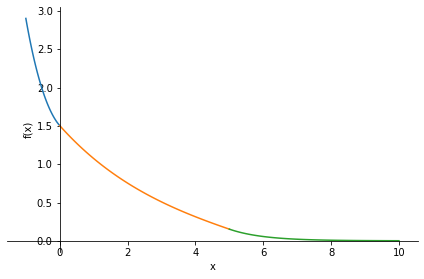

In [144]:
sp.plot( *psi_numerical )

In [145]:
psi_numerical[ 0 ][ 0 ]

0.503253019944681*exp(1.0*x) + exp(-1.0*x)

In [146]:
psi_numerical[ 1 ][ 0 ]

-0.0494308298002835*I*(-0.683772233983162*I*exp(0.632455532033676*x) + 31.0950161078632*I)*exp(-0.316227766016838*x)

In [147]:
psi_numerical[ 2 ][ 0 ]

22.551746199257*exp(-1.0*x)

In [148]:
wave_numbers[ k_0 ]

1.0*I

In [149]:
wave_numbers[ k_1 ]

0.316227766016838

In [150]:
scalar = 10e30

In [151]:
plancks_constant = 6.626068# * 10e-34 * scalar

In [152]:
reduced_plancks_constant = plancks_constant / ( 2 * sp.pi )

In [153]:
reduced_plancks_constant = reduced_plancks_constant.evalf()

In [154]:
electron_mass = 9.109# * 10e-31 * scalar * 10e-2

In [155]:
electron_total_energy = electron_mass * 10

In [156]:
barrier_energy = electron_total_energy * 4.0

In [157]:
barrier_length = plancks_constant

In [158]:
physical_wave_numbers = {
    k_0 : sp.sqrt( -numerical_beta_squared( electron_total_energy, electron_mass, reduced_plancks_constant ) ), 
    k_1 : sp.sqrt( numerical_k_squared( electron_total_energy, reduced_plancks_constant, electron_mass, reduced_plancks_constant ) )
}

In [159]:
base_steps = int( barrier_length / reduced_plancks_constant )

In [160]:
physical_domains = [
        ( -.005 * barrier_length, 0.0 ), 
        ( 0.0, barrier_length ), 
        ( barrier_length, 2 * barrier_length )
    ]

In [161]:
physical_psi_numerical = make_psi_numerical( psi_final, physical_wave_numbers, physical_domains, barrier_length )

In [162]:
conjugate_functions = lambda functions : tuple( ( ( function[ 0 ] * sp.conjugate( function[ 0 ] ) ).simplify(), function[ 1 ] ) for function in functions )

In [163]:
real_function = lambda functions : tuple( ( function[ 0 ].as_real_imag()[ 0 ], function[ 1 ] ) for function in functions )

In [164]:
imaginary_function = lambda functions : tuple( ( function[ 0 ].as_real_imag()[ 1 ], function[ 1 ] ) for function in functions )

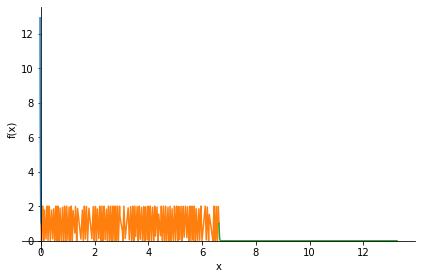

In [165]:
sp.plot( *conjugate_functions( physical_psi_numerical ), points = 1000000 )

In [166]:
def all_transform_combos( functions, transforms = (
            lambda this : this, 
            conjugate_functions, 
            real_function, 
            imaginary_function
        ) ):
    total = []
    for ii in transforms: 
        for jj in transforms: 
            for kk in jj( ii( functions ) ):
                total.append( kk )
    return tuple( total )

In [167]:
all_transforms = all_transform_combos( physical_psi_numerical )

In [168]:
all_transforms[ 0 ][ 1 ]

(x, -0.03313034, 0.0)

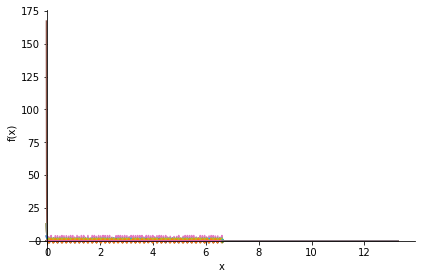

In [169]:
%matplotlib inline
sp.plot( *tuple( all_transforms ) )

In [170]:
physical_psi_numerical[ 0 ][ 0 ]

(2967.0719878285 - 2967.0719878285*exp(508.940404756209*I))*exp(38.6286632645786*x)/(17.2752633879093 - 2967.02169628593*I - 2967.02169628593*I*exp(508.940404756209*I) - 17.2752633879093*exp(508.940404756209*I)) + exp(-38.6286632645786*x)